# 1. Data Preparation

## Reading in the Data

In [4]:
# Set the working directory.
import os
wd = r"C:\Users\Jiseong Yang\git_projects\Marketing-Management"
wd = wd.replace("'\'", "/")
os.chdir(wd)
os.getcwd()

# Read in the data
import pandas as pd
import numpy as np

kidults_xlsx = "lego_kidults.xlsx"
kidults_csv = "lego_kidults.csv"
kidults = pd.read_excel(kidults_xlsx)
kidults.to_csv(kidults_csv, encoding = 'utf-8')
kidults = pd.read_csv(kidults_csv, encoding = "utf-8")

# Check the data.
kidults.head()
kidults.shape
kidults

# Set the mmaximum number of rows displayed.
pd.options.display.max_columns = 15

## Data Preprocessing

In [7]:
# Create lists of values to map
sex = ["남성", "여성"]
region = ["서울특별시", "인천광역시", "대전광역시", "대구광역시", "울산광역시",
          "부산광역시", "광주광역시", "세종특별자치시", "경기도", "강원도",
          "충청북도", "충청남도", "전라북도", "전라남도", "경상북도", 
          "경상남도", "제주특별자치도"]
bought = ['구입한 적 있음', '구입한 적은 없으나 앞으로 구입할 의사가 있음',
          "구입한 적이 없으며 앞으로 구입할 의사도 없음"]
my_purpose = ["선물", "수집", "완구", "교구재", "전시용"]

# Erase the weird sex category. 
raw_cols = kidults.columns
kidults = kidults[(kidults[raw_cols[1]] == "남성") | (kidults[raw_cols[1]] == "여성")]

In [8]:
# Remove the last three columns that are unneccessary. 
kidults = pd.DataFrame(kidults)
kidults.columns[-3:]
kidults.drop(kidults.columns[-3:], axis = 1, inplace = True)

# Remove the first column that are redundant.
kidults.drop(kidults.columns[0], axis = 1, inplace = True)

In [9]:
# Split the dataset into three parts and merge with the ID column.
kidults.columns[48:50]
demo = kidults.iloc[:,:8]
demo.columns

brand = kidults.iloc[:,8:48]
brand.columns

mix = kidults.iloc[:,48:]
mix.columns

demo.shape
brand.shape
mix.shape

# Check
kidults.shape[1] == demo.shape[1] + brand.shape[1] + mix.shape[1]

True

In [10]:
# Get the new and old lists of demographic dataset columns. 
demo_oldcols = demo.columns
demo_newcols = ["sex", "age", "region", "income", "bought", "my_purpose", "present_purpose", "present_age"]
len(demo_oldcols) == len(demo_newcols)

# Get the new and old lists of brand perception dataset columns.
brand_oldcols = brand.columns
brand_newcols = []
questions = ["price", "purpose", "popularity", "accuracy"]
for i in range(1, 11):
    for j in range(4):
        brand_newcols.append(questions[j] + str(i))
len(brand_oldcols) == len(brand_newcols)

# Get the new and old lists of marketing mix perception dataset columns.
mix_oldcols = mix.columns
mix_newcols = []
marketing_mix = ["product", "price", "place", "promotion"]
for i in range(4):
    for j in range(1,5):
        mix_newcols.append(marketing_mix[i] + str(j))
mix_newcols.append("overall")
len(mix_oldcols) == len(mix_newcols)

# Define the function that creates a dictionary of the old and new column names.
def get_col_dic(oldcols, newcols):
    col_dic = {}
    for i in range(len(oldcols)):
        col_dic[oldcols[i]] = newcols[i]
    return col_dic

# Assign the dictionaries created by the fucntion and rename the column names.        
demo_columns_dic = get_col_dic(demo_oldcols, demo_newcols)
brand_columns_dic = get_col_dic(brand_oldcols, brand_newcols)
mix_columns_dic = get_col_dic(mix_oldcols, mix_newcols)

demo.rename(columns=demo_columns_dic, inplace=True)
brand.rename(columns=brand_columns_dic, inplace=True)
mix.rename(columns=mix_columns_dic, inplace=True)

# Arrange the column order.
demo_col_rearrange = ['sex', 'region', 'bought', 'my_purpose', 
                      'present_purpose', 'present_age', 'age', 'income']
demo = demo[demo_col_rearrange]

In [11]:
# Encode the first dataset (demographic dataset)
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest

# Drop the gift-related columns. 
demo.columns
demo.drop(demo.columns[4:6], axis =1, inplace = True)

# Get the mapping dictionaries.
age_mapping = {
        "12세 미만": 0,
        "12세 이상 19세 미만": 1, 
        "19세 이상 29세 미만": 2, 
        "29세 이상 30세 미만": 3, 
        "30세 이상 40세 미만": 3, 
        "40세 이상 50세 미만": 4, 
        "50세 이상 60세 미만": 5, 
        "60세 이상": 6
        }

sex_mapping = {sex: i for i, sex in enumerate(sex)}
region_mapping = {region: i for i, region in enumerate(region)}
bought_mapping = {bought: i for i, bought in enumerate(bought)}
my_purpose_mapping = {my_purpose: i for i, my_purpose in enumerate(my_purpose)}
    
# Fix the error of the survey question that inquire the age range and encode the ordinal features. (age)    
demo.age = demo.age.map(age_mapping)
set(demo.age)

# Encode the nominal features. (sex, region, bought, my_purpose)
nominal_features = ["sex", "region", "bought", "my_purpose"]
demo[nominal_features[0]] = demo[nominal_features[0]].map(sex_mapping)
demo[nominal_features[1]] = demo[nominal_features[1]].map(region_mapping)
demo[nominal_features[2]] = demo[nominal_features[2]].map(bought_mapping)
demo[nominal_features[3]] = demo[nominal_features[3]].map(my_purpose_mapping)
    
# Features by types
demo_categorical = ["sex", "region", "bought", "my_purpose"]
demo_numerical = ["age", "income"]
   
# Add the knowledge level on brands as features to the demographic dataset. 
knowledge = brand[brand.filter(regex="^accuracy").columns]
demo_numerical = pd.concat([demo[demo_numerical], knowledge], axis = 1)

In [12]:
# Scale the numerical features. 
from sklearn.preprocessing import StandardScaler

# Normailze
stds = StandardScaler()
stds.fit(demo_numerical)
demo_stds = pd.DataFrame(stds.transform(demo_numerical))

# Rename the columns
demo_stds.shape[1]
demo_numerical.shape[1]
demo_stds.rename(columns=get_col_dic(demo_stds.columns, demo_numerical.columns), inplace = True)

# Concatenate the scaled table with categorical tables.
demo = pd.concat([demo[demo_categorical], demo_stds], axis =1)
demo

,sex,region,bought,my_purpose,age,income,accuracy1,...,accuracy4,accuracy5,accuracy6,accuracy7,accuracy8,accuracy9,accuracy10
0,0.0,5.0,0.0,1.0,0.074860,-2.075775,0.731517,...,0.215357,2.057815,2.145346,-0.758711,-1.151213,-1.386355,-1.203206
1,0.0,0.0,0.0,1.0,-0.985654,-0.287523,0.731517,...,-0.801605,-1.010857,-1.039884,-0.758711,-0.480986,-1.386355,-1.203206
2,0.0,10.0,0.0,1.0,-2.046167,0.904645,0.731517,...,0.215357,-1.010857,-1.039884,-0.758711,-1.151213,0.681016,1.598780
3,0.0,0.0,0.0,2.0,0.074860,0.308561,-2.377430,...,-1.818567,-1.010857,-1.039884,-0.758711,-1.151213,-1.386355,-1.203206
4,0.0,3.0,0.0,1.0,-0.985654,-0.287523,-0.822957,...,0.215357,-1.010857,-1.039884,-0.758711,0.859468,-0.008107,0.898284
5,0.0,9.0,0.0,2.0,0.074860,0.308561,0.731517,...,1.232318,2.057815,-0.243576,0.089847,-1.151213,1.370140,-0.502709
6,0.0,1.0,0.0,2.0,1.135373,-2.075775,0.731517,...,1.232318,-0.243689,-0.243576,-0.758711,-1.151213,1.370140,0.898284
7,0.0,13.0,0.0,1.0,0.074860,0.308561,-0.822957,...,-1.818567,-0.243689,-0.243576,-0.758711,0.189241,-0.697231,-1.203206
8,0.0,1.0,0.0,2.0,-2.046167,-0.287523,0.731517,...,-1.818567,-1.010857,-0.243576,-0.758711,-1.151213,1.370140,1.598780
9,0.0,1.0,0.0,1.0,-0.985654,-0.287523,-0.822957,...,-0.801605,-1.010857,-1.039884,-0.758711,-0.480986,-0.697231,0.197787


## Segment the Data by the Level of Knowledge

In [13]:
# Getting a list of each company's data.
brands_data = []
for i in range(1,11):
    brands_data.append(brand.iloc[:,(i-1)*4:i*4])

# Define the function that adds the ID columns.
def concat_id(dataset_whole, dataset_brand):
    import pandas as pd
    dataset_brand = pd.concat([dataset_whole[dataset_whole.columns[0]], dataset_brand], axis = 1)
    dataset_brand.rename(columns = {dataset_brand.columns[0]: "ID"}, inplace = True)
    return dataset_brand

# Get the dataset for each brand.
lego, sonogong, young_toys, oxford, froebel, montessori, edu_hansol, riot_games, pubg, mojang = brands_data

# Get the dataset of each brand.
brand_perception_by_knowledge = []

# Store them all in a single list.
for name in brands_data:
    # Combine the dataset with ID columns. 
    name = concat_id(kidults, name) 
    
    # Filter out the dataset depending on the accuarcy.
    brand_ignorant = name[name[name.columns[4]] < 3]
    brand_moderate = name[name[name.columns[4]] == 3]
    brand_knowledgeable = name[name[name.columns[4]] > 3]
    
    # Append three different gruops by the level of knowledge to a single list. 
    brand_perception_by_knowledge.append([brand_ignorant, brand_moderate, brand_knowledgeable])

# Wait for a second to prevent the errors.
import time
time.sleep(1)        
  

## Brand Perception Data

In [14]:
# Lego
# Ignorant group
lego_ignorant = brand_perception_by_knowledge[0][0]
lego_ignorant_average = lego_ignorant.describe().iloc[1,:3]

# Moderate Group
lego_moderate = brand_perception_by_knowledge[0][1]
lego_moderate_average = lego_moderate.describe().iloc[1,:3]

# Knowledgeable Group
lego_knowledgeable = brand_perception_by_knowledge[0][2]
lego_knowledgeable_average = lego_knowledgeable.describe().iloc[1,:3]

# Sonogong
# Ignorant group
sonogong_ignorant = brand_perception_by_knowledge[1][0]
sonogong_ignorant_average = sonogong_ignorant.describe().iloc[1,:3]

# Moderate Group
sonogong_moderate = brand_perception_by_knowledge[1][1]
sonogong_moderate_average = sonogong_moderate.describe().iloc[1,:3]

# Knowledgeable Group
sonogong_knowledgeable = brand_perception_by_knowledge[1][2]
sonogong_knowledgeable_average = sonogong_knowledgeable.describe().iloc[1,:3]

# Young Toys
# Ignorant group
young_toys_ignorant = brand_perception_by_knowledge[2][0]
young_toys_ignorant_average = young_toys_ignorant.describe().iloc[1,:3]

# Moderate Group
young_toys_moderate = brand_perception_by_knowledge[2][1]
young_toys_moderate_average = young_toys_moderate.describe().iloc[1,:3]

# Knowledgeable Group
young_toys_knowledgeable = brand_perception_by_knowledge[2][2]
young_toys_knowledgeable_average = young_toys_knowledgeable.describe().iloc[1,:3]

# Oxford
# Ignorant group
oxford_ignorant = brand_perception_by_knowledge[3][0]
oxford_ignorant_average = oxford_ignorant.describe().iloc[1,:3]

# Moderate Group
oxford_moderate = brand_perception_by_knowledge[3][1]
oxford_moderate_average = oxford_moderate.describe().iloc[1,:3]

# Knowledgeable Group
oxford_knowledgeable = brand_perception_by_knowledge[3][2]
oxford_knowledgeable_average = oxford_knowledgeable.describe().iloc[1,:3]

# Froebel
# Ignorant group
froebel_ignorant = brand_perception_by_knowledge[4][0]
oxford_ignorant_average = oxford_ignorant.describe().iloc[1,:3]

# Moderate Group
froebel_moderate = brand_perception_by_knowledge[4][1]
froebel_moderate_average = froebel_moderate.describe().iloc[1,:3]

# Knowledgeable Group
froebel_knowledgeable = brand_perception_by_knowledge[4][2]
froebel_knowledgeable_average = froebel_knowledgeable.describe().iloc[1,:3]

# Montessori
# Ignorant group
montessori_ignorant = brand_perception_by_knowledge[5][0]
montessori_ignorant_average = montessori_ignorant.describe().iloc[1,:3]

# Moderate Group
montessori_moderate = brand_perception_by_knowledge[5][1]
montessori_moderate_average = montessori_moderate.describe().iloc[1,:3]

# Knowledgeable Group
montessori_knowledgeable = brand_perception_by_knowledge[5][2]
montessori_knowledgeable_average = montessori_knowledgeable.describe().iloc[1,:3]

# Edu Hansol
# Ignorant group
edu_hansol_ignorant = brand_perception_by_knowledge[6][0]
edu_hansol_ignorant_average = edu_hansol_ignorant.describe().iloc[1,:3]

# Moderate Group
edu_hansol_moderate = brand_perception_by_knowledge[6][1]
edu_hansol_moderate_average = edu_hansol_moderate.describe().iloc[1,:3]

# Knowledgeable Group
edu_hansol_knowledgeable = brand_perception_by_knowledge[6][2]
edu_hansol_knowledgeable_average = edu_hansol_knowledgeable.describe().iloc[1,:3]

# Riot Games
# Ignorant group
riot_games_ignorant = brand_perception_by_knowledge[7][0]
riot_games_ignorant_average = riot_games_ignorant.describe().iloc[1,:3]

# Moderate Group
riot_games_moderate = brand_perception_by_knowledge[7][1]
riot_games_moderate_average = riot_games_moderate.describe().iloc[1,:3]

# Knowledgeable Group
riot_games_knowledgeable = brand_perception_by_knowledge[7][2]
riot_games_knowledgeable_average = riot_games_knowledgeable.describe().iloc[1,:3]

# PUBG
# Ignorant group
pubg_ignorant = brand_perception_by_knowledge[8][0]
pubg_ignorant_average = pubg_ignorant.describe().iloc[1,:3]

# Moderate Group
pubg_moderate = brand_perception_by_knowledge[8][1]
pubg_moderate_average = pubg_moderate.describe().iloc[1,:3]

# Knowledgeable Group
pubg_knowledgeable = brand_perception_by_knowledge[8][2]
pubg_knowledgeable_average = pubg_knowledgeable.describe().iloc[1,:3]

# Mojang
# Ignorant group
mojang_ignorant = brand_perception_by_knowledge[9][0]
mojang_ignorant_average = mojang_ignorant.describe().iloc[1,:3]

# Moderate Group
mojang_moderate = brand_perception_by_knowledge[9][1]
mojang_moderate_average = mojang_moderate.describe().iloc[1,:3]

# Knowledgeable Group
mojang_knowledgeable = brand_perception_by_knowledge[9][2]
mojang_knowledgeable_average = mojang_knowledgeable.describe().iloc[1,:3]   


In [15]:
# Concatenating all the datasets by the level of knowledge.
# Set the hyper parameter
price_index = [i*3 for i in range(10)]    
purpose_index = [i*3+1 for i in range(10)]
popularity_index = [i*3+2 for i in range(10)]
    
# Get the ignorant perceptual data.
ignorant_average = [lego_ignorant_average, sonogong_ignorant_average, 
            young_toys_ignorant_average, oxford_ignorant_average, \
            froebel_knowledgeable_average, montessori_knowledgeable_average, 
            edu_hansol_ignorant_average, riot_games_ignorant_average,
            pubg_ignorant_average, mojang_ignorant_average]

ignorant = pd.concat(ignorant_average, axis = 0)
ignorant

ignorant_price = ignorant[price_index]
ignorant_purpose = ignorant[purpose_index]
ignorant_popularity = ignorant[popularity_index]

# Convert the values into lists
ignorant_price = list(ignorant_price)
ignorant_purpose = list(ignorant_purpose)
ignorant_popularity = list(ignorant_popularity)

# The moderate.
moderate_average = [lego_moderate_average, sonogong_moderate_average, 
            young_toys_moderate_average, oxford_moderate_average, \
            froebel_knowledgeable_average, montessori_knowledgeable_average, 
            edu_hansol_moderate_average, riot_games_moderate_average,
            pubg_moderate_average, mojang_moderate_average]

moderate = pd.concat(moderate_average, axis = 0)
moderate

moderate_price = moderate[price_index]
moderate_purpose = moderate[purpose_index]
moderate_popularity = moderate[popularity_index]

# Convert the values into lists
moderate_price = list(moderate_price)
moderate_purpose = list(moderate_purpose)
moderate_popularity = list(moderate_popularity)
    
# The Knowledgeable.
knowledgeable_average = [lego_knowledgeable_average, sonogong_knowledgeable_average, 
            young_toys_knowledgeable_average, oxford_knowledgeable_average, 
            froebel_knowledgeable_average, montessori_knowledgeable_average, 
            edu_hansol_knowledgeable_average, riot_games_knowledgeable_average,
            pubg_knowledgeable_average, mojang_knowledgeable_average]

knowledgeable = pd.concat(knowledgeable_average, axis = 0)
knowledgeable

knowledgeable_price = knowledgeable[price_index]
knowledgeable_purpose = knowledgeable[purpose_index]
knowledgeable_popularity = knowledgeable[popularity_index]

# Convert the values into lists
knowledgeable_price = list(knowledgeable_price)
knowledgeable_purpose = list(knowledgeable_purpose)
knowledgeable_popularity = list(knowledgeable_popularity)


## Marketing Mix Data

In [17]:
# Preprocesing for Regression Analysis.
mix
mix.describe()

mix_product = mix.iloc[:,:4]
mix_price = mix.iloc[:,4:8]
mix_place = mix.iloc[:,8:12]
mix_promotion = mix.iloc[:,12:16]

mix_product.corr().iloc[0,:]
np.mean(mix_product.corr().iloc[0,:])

# Create ID column as the first column.
demo["id"] = [i+1 for i in range(demo.shape[0])]
demo = demo[["id",'sex', 'region', 'bought', 'my_purpose', 'age', 'income', 'accuracy1',
       'accuracy2', 'accuracy3', 'accuracy4', 'accuracy5', 'accuracy6',
       'accuracy7', 'accuracy8', 'accuracy9', 'accuracy10']]

# Concatenate demographic and marketing mix columns (especially, for the regression analysis)
#demo_mix = pd.concat([demo, mix], axis = 1)



# 2. Data Analysis

## Perceptual Map Visualization

In [18]:
# Import required modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D

# Define a function that flattens the lists of lists.
def flatten(list):
    flattened_list = []
    for i in range(len(list)):
        for j in range(len(list[i])):
            flattened_list.append(list[i][j])
    return flattened_list

In [19]:
# Hyperparameters
brand_names =["Lego", "Sonogong", 
              "Young Toys", "Oxford",
              "Froebel", "Montessori",
              "Edu Hansol", "Riot Games",
              "PUBG", "Mojang"]

colors = ["blue", "green", "red"]
markers = ["o", "^", "x"]
industries = ["Toys", "Education", "Games"]

color_range = [[0]] + [[i] * 3 for i in range(3)]
color_range_flattened = flatten(color_range)

marker_range = [[0]] + [[i, i+1, i+2] * 3 for i in range(1)]
marker_range_flattened = flatten(marker_range)

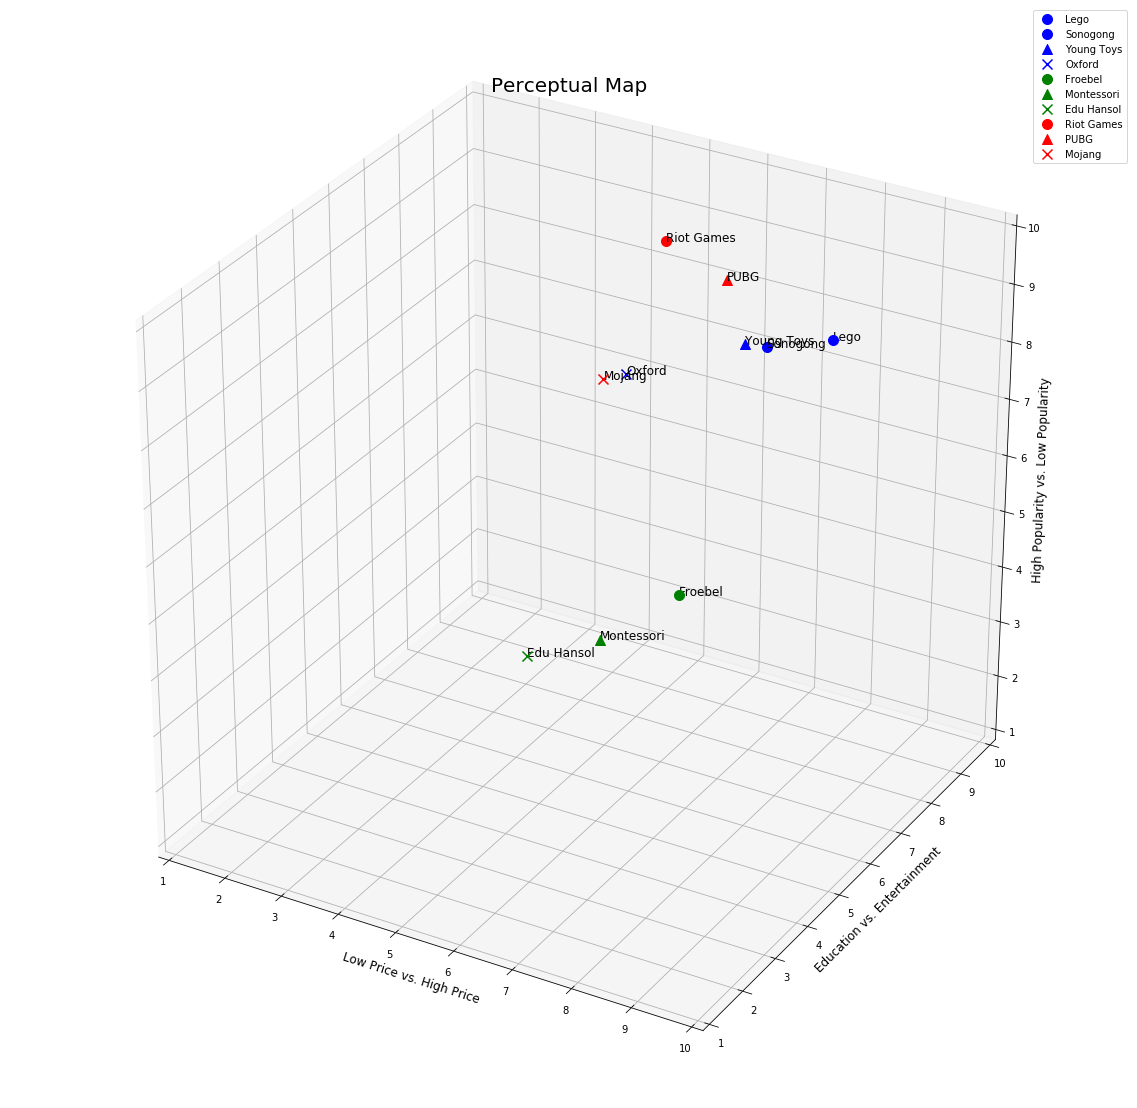

In [23]:
# Plot the data
import pandas as pd

# Get the axes.
fig3 = plt.figure(figsize=(20,20))
ax = fig3.add_subplot(111, projection='3d')

# Get the data.
X1 = knowledgeable_price
Y1 = knowledgeable_purpose
Z1 = knowledgeable_popularity

# Plot the data
for i in range(10): 
    ax.scatter(X1[i], Y1[i], Z1[i], label = brand_names[i], \
               c = colors[color_range_flattened[i]], marker = markers[marker_range_flattened[i]], \
               s=100)
    
# Plot the text
for i in range(len(brand_names)):
    ax.text(X1[i], Y1[i], Z1[i], brand_names[i], fontsize = 12)

# Set the axes range
ax.set_xlim3d(1, 10)
ax.set_ylim3d(1, 10)
ax.set_zlim3d(1, 10)

# Set the lable
ax.set_xlabel("Low Price vs. High Price", fontsize = 12)
ax.set_ylabel("Education vs. Entertainment", fontsize = 12)
ax.set_zlabel("High Popularity vs. Low Popularity", fontsize = 12)
ax.set_title("Perceptual Map", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.)

plt.show()



In [27]:
# Mean Comparison
import numpy as  np
import pandas as pd
from scipy import stats as st

# Create a table with mean of each mixes.
# Mean
mix_overall_mean = np.mean(mix.iloc[:,-1])
mix_product_mean_total = np.mean(np.mean(mix_product))
mix_price_mean_total = np.mean(np.mean(mix_price))
mix_place_mean_total = np.mean(np.mean(mix_place))
mix_promotion_mean_total = np.mean(np.mean(mix_promotion))

mix_product_mean = pd.DataFrame(np.mean(mix_product)).T
mix_product_mean.insert(column = "product_mean", value = mix_product_mean_total, loc = 4)

mix_price_mean = pd.DataFrame(np.mean(mix_price)).T
mix_price_mean.insert(column = "price_mean", value = mix_price_mean_total, loc = 4)

mix_place_mean = pd.DataFrame(np.mean(mix_place)).T
mix_place_mean.insert(column = "place_mean", value = mix_place_mean_total, loc = 4)

mix_promotion_mean = pd.DataFrame(np.mean(mix_promotion)).T
mix_promotion_mean.insert(column = "promotion_mean", value = mix_promotion_mean_total, loc = 4)

# Intra-comparison
# Get mean
print(mix_product_mean)
print(mix_price_mean)
print(mix_place_mean)
print(mix_promotion_mean)

# Inter-comparison
mix_mean_overall_dict = {
        "product": [mix_product_mean_total],
        "price": [mix_price_mean_total],
        "place": [mix_place_mean_total],
        "promotion": [mix_promotion_mean_total],
        "overall": [mix_overall_mean],
        "average": np.mean([mix_product_mean_total, mix_price_mean_total, mix_place_mean_total, mix_promotion_mean_total])        
                 }
mix_mean_overall = pd.DataFrame(data=mix_mean_overall_dict)
print(mix_mean_overall)

   product1  product2  product3  product4  product_mean
0  4.070588  4.317647  4.235294  3.788235      4.102941
     price1    price2    price3    price4  price_mean
0  2.305882  2.341176  2.423529  2.282353    2.338235
     place1    place2    place3    place4  place_mean
0  3.023529  2.847059  3.105882  3.917647    3.223529
   promotion1  promotion2  promotion3  promotion4  promotion_mean
0    3.329412    2.835294    2.870588    3.211765        3.061765
    product     price     place  promotion   overall   average
0  4.102941  2.338235  3.223529   3.061765  2.576471  3.181618
